# **Caligraphy reader model with skealrn**

# **Data preparation**

In [40]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", as_frame = False)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [41]:
X = mnist.data
y = mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [43]:
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')

X.shape = (70000, 784)
y.shape = (70000,)


On a 70 000 images dans notre table de données

Nous allons représenter certaines de ces images

In [44]:
import matplotlib.pyplot as plt

def plot_digits(image_data, num_rows=1, num_cols=5):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))
    for i, ax in enumerate(axes.flat):
        ax.imshow(image_data[i].reshape(28, 28), cmap="binary")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

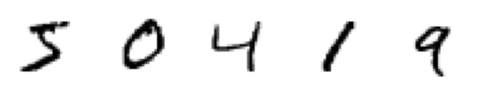

In [45]:
plot_digits(X[:5])

In [46]:
digit=X[0]
for i in range(5):
  print(y[i])

5
0
4
1
9


Les valeurs sont bien celles des images ci-dessus

# **Data Split**

In [47]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000]

# **Binary classifier training**

On simplifie le problème dans un premier temps et on se contente de reconnaitre les '5'

In [48]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [49]:
from sklearn.linear_model import SGDClassifier
binary_classifier = SGDClassifier(random_state=42)
binary_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

on le test sur X[0] car on sait que c'est un 5

In [50]:
binary_classifier.predict([digit])

array([ True])

Il detecte en effet que c'est un 5

# **Test de performance**

In [51]:
from sklearn.model_selection import cross_val_score

cross_val_score(binary_classifier,  X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Le résultat ici est à nuancé, en effet le score affiche 95% de précision mais en réalité il y a peu de 5 donc lorsque le model ne reconnait pas un 5 il a 90% de chance d'avoir juste. (voir si dessous un le score d'un modèle qui renvooit faux à chaque fois)

In [52]:
from sklearn.dummy  import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

Traçons d'abord la matrice de confusion : (5 , non 5)

In [53]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_prediction = cross_val_predict(binary_classifier, X_train, y_train_5, cv=3)
cm = confusion_matrix(y_train_5, y_train_prediction)
cm

array([[53892,   687],
       [ 1891,  3530]])

on peut lire la matrice de la façon suivante : 53 892 non 5 on été bien classés et 687 on été considérés comme des 5. En revanche 1891 5 on été considéré comme non 5

# **Définition de la précision**

précision = True positive /(True positive + False Positive)

rappel = True positive /(True Positive + False Ngative)

In [54]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_prediction)

0.8370879772350012

lorsque le modèle affirme reconnaitre un 5, il y a 83,7% de chance d'avoir juste

In [55]:
recall_score(y_train_5, y_train_prediction)

0.6511713705958311

Le modèle détecte que 65.1% des 5

On peut aussi définir le score F1 qui est la moyenne harmonique de la précision et du rappel

F1 = 2/(1/rappel + 1/precision)

In [56]:
from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_prediction)

0.7325171197343846

Le score f1 favorise les classifieur ayant une précision et un rappel proche


or parfois on préfére de pas sélectionner des élements valables pour limiter le risque et donc avoir une précision plus important -> faible rappel et haute précision

On peut aussi préférer un rappel plus haut et une précision plus faible en fonction des cas

In [57]:
y_scores = cross_val_predict(binary_classifier, X_train, y_train_5, cv=3, method="decision_function")

In [58]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshold = precision_recall_curve(y_train_5, y_scores)

on trace maintenant les courbes de précision et rappel en fonction du seuil

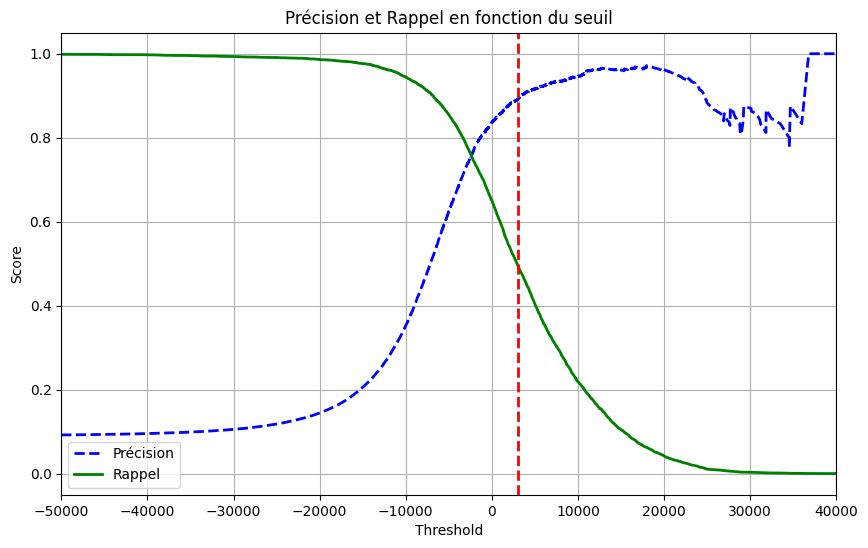

In [59]:
import numpy as np
plt.figure(figsize=(10, 6))
plt.grid(True)

plt.plot(threshold, precisions[:-1], "b--", label="Précision", linewidth=2)
plt.plot(threshold, recalls[:-1], "g-", label="Rappel", linewidth=2)
plt.axvline(x=3000, color='r', linestyle='--', linewidth=2)


plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Précision et Rappel en fonction du seuil')

plt.xlim(-50000, 40000)
plt.legend()

plt.show()

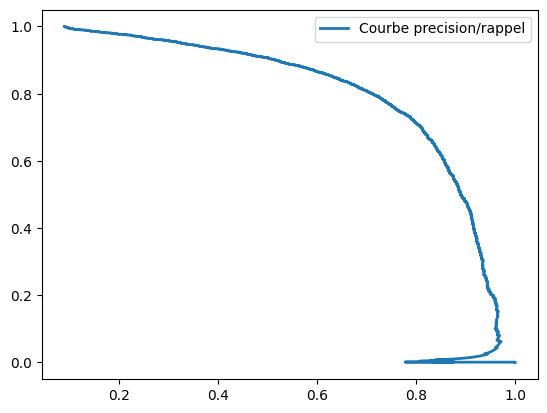

In [60]:
plt.plot(precisions, recalls, linewidth=2, label="Courbe precision/rappel")
plt.legend()
plt.show()

On fixe notre précision cible : 95%
selon le graphe ci-dessus correspond à environ 20% de rappel

recherche du seuil correspondant

In [61]:
idx_for_95_precision = (precisions>0.95).argmax()
threshold_for_95_precision = threshold[idx_for_95_precision]
threshold_for_95_precision

10480.508645329961

In [62]:
y_train_pred_95 = (y_scores >= threshold_for_95_precision )

In [63]:
precision_score(y_train_5, y_train_pred_95)

0.9503367003367004

On a bien une précision de 95%

In [64]:
 recall_at_95_precision = recall_score(y_train_5, y_train_pred_95)
 recall_at_95_precision

0.20826415790444566


le recall correspondant est donc de 21%



**Courbe ROC**

C'est une coubre représentant en en x le taux de faux positifs et en y le taux de vrais positifs

In [66]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds= roc_curve(y_train_5, y_scores)

<ipython-input-73-ef21c175cd36>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot([fpr_95],[tpr_95],"ko", label="Seuil pour précisions 95%", color="red")


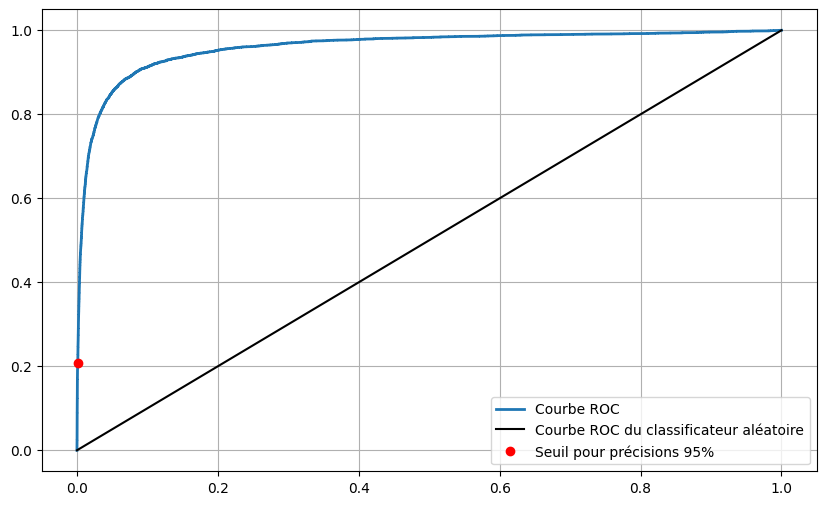

In [73]:
idx_for_95_precision = (thresholds <= threshold_for_95_precision).argmax()
tpr_95, fpr_95 = tpr[idx_for_95_precision], fpr[idx_for_95_precision]


plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(fpr, tpr, linewidth=2, label ="Courbe ROC")
plt.plot([0,1],[0,1],"k", label="Courbe ROC du classificateur aléatoire")
plt.plot([fpr_95],[tpr_95],"ko", label="Seuil pour précisions 95%", color="red")
plt.legend()
plt.show()

Pour comparer des classificateurs entre eux on peut alors calculer l'air sous les courbes ROC, celui pour lequel la valeur est plus proche de 1  est le meilleur (on appelle cette estimateur AUC : area under the curve)

In [74]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

**Nouveau classificateur à tester RandomForest**

In [75]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [77]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [78]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

cela signifie que la premiere image a 89% de chance d'être un 5 et 11% de ne pas l'être, de même la seconde a 99% de chance de ne pas l'être

On va donc pouvoir tracer la courbe de precision/recall

In [79]:
y_scores_forest = y_probas_forest[:,1]
precisions_forest, recall_forest, threshold_forest = precision_recall_curve(y_train_5,y_scores_forest)

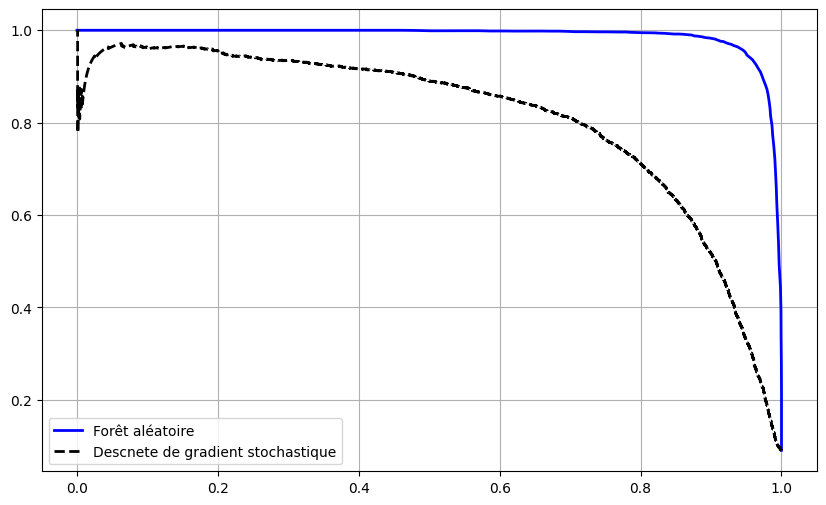

In [84]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(recall_forest, precisions_forest, "b-",linewidth=2, label ="Forêt aléatoire")
plt.plot(recalls, precisions,"--",linewidth=2, label="Descnete de gradient stochastique", color="black")
plt.xlabel="Rappel"
plt.ylabel="Précision"
plt.legend()
plt.show()

vérifions le f1 score et le AUC

In [86]:
y_pred_forest= y_probas_forest[:,1]>=0.5
f1_score(y_train_5, y_pred_forest)

0.9274509803921569

In [87]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

precisions :

In [88]:
precision_score(y_train_5, y_pred_forest)

0.9897468089558485

rappel :

In [89]:
recall_score(y_train_5, y_pred_forest)

0.8725327430363402

Le classificateur Random forest est plus efficace que le classificateur vu précedement

# **classificateur multi-classes**

Nous effectuerons l'entrainement du modèle sur les 3000 premières valeurs pour limiter la durée d'éxecution

In [92]:
from sklearn.svm import SVC
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:3000], y_train[:3000])

SVC(random_state=42)

In [93]:
svm_clf.predict([X[0]])

array(['5'], dtype=object)

Ce classificateur fonctionne selon la strategie OvO c'est à dire qu'il est en réalité composé de 45 classificateurs binaire (une par paire de chiffres possible) (N*(N-1)/2). il sélectionne le chiffre qui a remporté le plus de duels

Une autre stratégie possible est celle OvR -> créer 10 détécteurs, un par chiffre comme nous l'avons fait au dessus pour 5 et voir celui qui obtient le meuilleur score pour chaque images (nous ne la verrons pas ici)

In [94]:
premiere_image_scores = svm_clf.decision_function([X[0]])
premiere_image_scores.round(2)

array([[ 3.77,  0.73,  6.13,  8.3 , -0.3 ,  9.3 ,  1.74,  3.79,  7.21,
         3.82]])

on voit bien que le score le plus élevée est en 6eme positions donc c'est le chiffre 5